## Parameters Optimization

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import datetime

import scipy.optimize as spo
import scipy.integrate as spi

We will be using the same SEIR model as part1.

![title](model.png)

$\begin{aligned}
&\frac{dS}{dt}&
&=& - \lambda \frac{S}{N} E - c\lambda \frac{S}{N} kI + \alpha R
\\
&\frac{dE}{dt}&
&=&   \lambda \frac{S}{N} E + c\lambda \frac{S}{N} kI - \sigma E
\\
&\frac{dI}{dt}&
&=& \sigma E - \mu I - \omega I 
\\
&\frac{dX}{dt}&
&=& \omega I 
\\
&\frac{dR}{dt}&
&=& \mu I - \alpha R 
\end{aligned}$

$S + E + I + R + X = N,~ I = Q + H$

The physical meanings of the parameters:
* $\lambda$, $c\lambda$: infection rate, which should have a direct relationship with the strength of the control policy (how many days should people in self-quarantine stay at home, how strict should the quarantine be, how should social distancing be enforced, whether or not people are required to wear a mask, etc).
* $\sigma$: we choose $\sigma = 1/14$ because the incubation period is 14 days on average.
* $k$: the proportion of positive cases that are not hospitalized, which should have a relationship with the current medical resources such as the number of hospital beds.
* $\mu, \omega$: recover rate and death rate, which should have a relationship with the current medical resources and the health condition of the population.
* $\alpha$: immunity lost rate, it depends on the characteristic of the virus and sometimes relates to the testing methods.

Among all above, an important limit to the control of the pandemic is medical resources. In other words, $k, \mu, \omega$ depends on the temporal situations of each states or countries. Another limit is the inherent feature of the COVID-19 virus itself, i.e. $\sigma$ and $\alpha$. 

However, the policy maker can decide on the control policy, which directly affects $\lambda$ and $c\lambda$. We know that the control policy is like a double-edged sword: if it is too strict, it would have a bad impact on the economy and people's social life; but if it is too relaxed, the pandemic will soon lose control, causing even more severe consequences.

Therefore, our solution is trying to find the best set of transmission parameters $\lambda$ and $c$ using optimization methods.
1. Given a state of interest and a start date, the algorithm will fetch for the pandemic  data of that region at that time. It will then take the original parameters as the first guess, and simulate the trend assuming all conditions stay the same in future.
2. With the control term (death / case) and the control factor (proportion of population) specified, the optimization algorithm will run to find the best set of parameters needed to satisfy the requirement. And by controlling the transmission parameters, the trend can also be visualized.
3. Ideally, this algorithm can be run dynamically using the real time data, so that the policy can be adjusted timely and effectively.

In [2]:
def control(state, date, control_term, control_factor, output=True):
    
    ### get params from model output for the chosen state and date

    # get params
    df_params = pd.read_csv("datasets/model_out.csv")
    df_params["startdate"] = pd.to_datetime(df_params["startdate"])
    df_params["enddate"] = pd.to_datetime(df_params["enddate"])
    df_params = df_params[ (df_params["state"]==state) & (df_params["startdate"] < date) & (df_params["enddate"] > date) ]
    k, sigma, lamda, c, alpha, omega, miu = float(df_params["k"]), float(df_params["sigma"]), float(df_params["lamda"]), float(df_params["c"]), float(df_params["alpha"]), float(df_params["omega"]), float(df_params["miu"])

    # get startpoint data
    df_state = pd.read_csv("datasets/timeseries_states/"+state+".csv")
    df_state["date"] = pd.to_datetime(df_state["date"])
    sample = df_state[df_state["date"] == date]
    sample_future = df_state[ df_state["date"] == date + np.timedelta64(14,'D') ]

    # get initial point
    cases = float(sample["cases"])
    cases_future = float(sample_future["cases"])
    N = float(sample["population"])
    X0 = float(sample["deaths"])
    R0 = float(sample["recovered"])
    I0 = cases - X0 - R0
    E0 = cases_future - cases
    S0 = N - E0 - I0 - X0 - R0
    
    
    ### differential equations for spi.odeint, INP - initial point, t - time range
    # dS/dt = - lamda*S/N*E - c*lamda*S/N*k*I + alpha*R
    # dE/dt =   lamda*S/N*E + c*lamda*S/N*k*I - sigma*E
    # dI/dt = sigma*E - miu*I - omega*I
    # dX/dt = omega*I
    # dR/dt = miu*I - alpha*R
    def diff_eqs(INP, t, lamda_p, c_p):
        Y = np.zeros((5))
        V = INP
        Y[0] = - lamda_p*V[0]/N*V[1] - c_p*lamda_p*V[0]/N*k*V[2] + alpha*V[4]
        Y[1] =   lamda_p*V[0]/N*V[1] + c_p*lamda_p*V[0]/N*k*V[2] - sigma*V[1]
        Y[2] = sigma*V[1] - miu*V[2] - omega*V[2]
        Y[3] = omega*V[2]
        Y[4] = miu*V[2] - alpha*V[4]
        return Y

    ### cost function for optimization
    def MSE(params):
        INP = (S0, E0, I0, X0, R0)
        t_range = np.arange(0, 150, 1)
        RES = spi.odeint(diff_eqs, INP, t_range, args=tuple(params))
        if control_term == "case":
            mse = ( max(RES[:,2]) - control_factor*N )**2
        elif control_term == "death":
            mse = ( max(RES[:,3]) - control_factor*N )**2
        else:
            mse = 0
            print("Incorrect control term, choose between 'case', or 'death'")
        return mse
    
    
    ### optimize to find the best params
    params0 = (lamda, c)
    ret = spo.minimize(MSE, params0, bounds=[(0,1), (0,1)])
    params = ret.x
    params0 = [round(i,8) for i in params0]
    params = [round(i,8) for i in params]
    
    if output:
        print("Params:")
        print("k:", k, "; sigma:", sigma, "; alpha:", alpha, "; omega:", omega, "; miu:", miu)
        print("Optimization for lamda, c")
        print("params0: ", params0)
        print("params: ", params)

        ### solve ode and plot
        INP = (S0, E0, I0, X0, R0)
        t_range = np.arange(0, 600, 1)
        RES0 = spi.odeint(diff_eqs, INP, t_range, args=tuple(params0))
        RES = spi.odeint(diff_eqs, INP, t_range, args=tuple(params))

        plt.figure(figsize=(10,6))
        plt.plot(RES0[:,1], '--b', label='E_original')
        plt.plot(RES0[:,2], '--r', label='I_original')
        plt.plot(RES0[:,3], '--k', label='X_original')
        plt.plot(RES0[:,4], '--g', label='R_original')
        plt.plot(RES[:,1], '-b', label='E_controlled')
        plt.plot(RES[:,2], '-r', label='I_controlled')
        plt.plot(RES[:,3], '-k', label='X_controlled')
        plt.plot(RES[:,4], '-g', label='R_controlled' )
        plt.legend()
        plt.title(state + ", start from" + str(date), fontsize = 14)
        plt.show();

        plt.figure(figsize=(10,6))
        plt.subplot(121)
        plt.plot(RES0[:,1], '--b', label='E_original')
        plt.plot(RES0[:,2], '--r', label='I_original')
        plt.plot(RES0[:,3], '--k', label='X_original')
        plt.plot(RES0[:,4], '--g', label='R_original')
        plt.subplot(122)
        plt.plot(RES[:,1], '-b', label='E_controlled')
        plt.plot(RES[:,2], '-r', label='I_controlled')
        plt.plot(RES[:,3], '-k', label='X_controlled')
        plt.plot(RES[:,4], '-g', label='R_controlled')
        plt.legend()
        plt.show();
        
    return params

### Examples: California, 2020-05-18

#### 1.1. Control for death, 0.05%
The model suggests to have a strict quanrantine on the positive cases (c is nearly zero) while keeping the other policies for citizens the same as before. As a result, we can see that it has a fairly good control of the pandemic and can avoid the outbreak in the future.

Params:
k: 0.95978763 ; sigma: 0.07142857 ; alpha: 0.03497201 ; omega: 0.00091574 ; miu: 0.01212794
Optimization for lamda, c
params0:  [0.04972483, 0.4054014]
params:  [0.065199, 0.41508681]


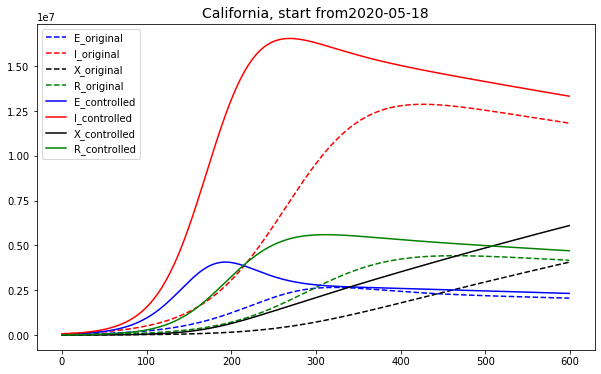

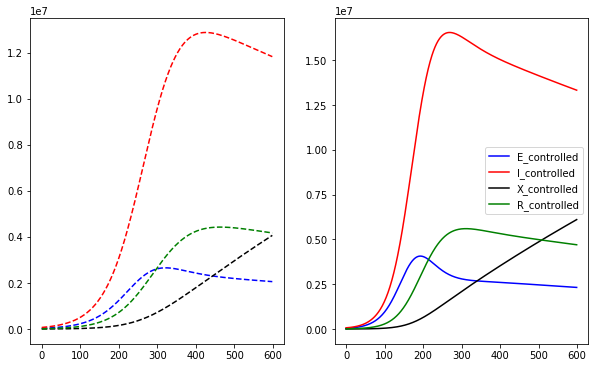

In [12]:
# control the death rate to 0.05% of the whole population
params = control("California", np.datetime64("2020-05-18"), "death", 5e-3)

#### 1.2. Control for death, 0.5%
The model suggests to have an even more relaxed policy as before ($\lambda$ and $c$ increase). But as a result, an outbreak is coming.

Params:
k: 0.95978763 ; sigma: 0.07142857 ; alpha: 0.03497201 ; omega: 0.00091574 ; miu: 0.01212794
Optimization for lamda, c
params0:  [0.04972483, 0.4054014]
params:  [0.065199, 0.41508681]


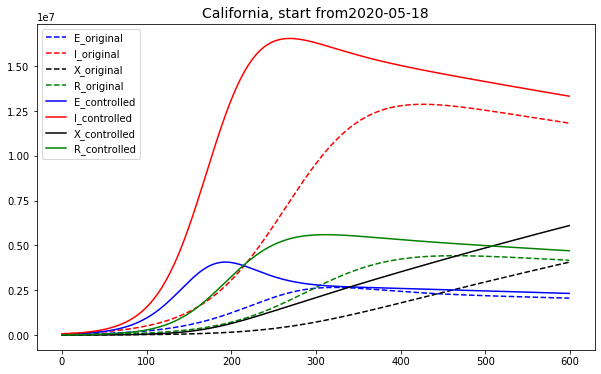

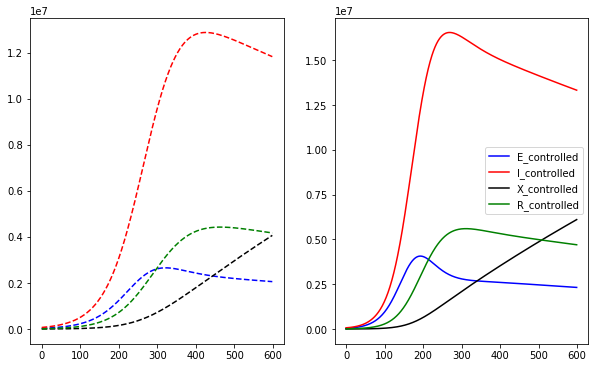

In [4]:
# control the death rate to 0.5% of the whole population
params = control("California", np.datetime64("2020-05-18"), "death", 5e-3)

#### 2.1. Control for case, 0.2%
The model suggests to have a strict quanrantine on the positive cases ($c$ is nearly zero) and have a stricter policy for citizens ($\lambda$ decreases). As a result, we can see that it has a fairly good control of the pandemic and can avoid the outbreak in the future.

Params:
k: 0.95978763 ; sigma: 0.07142857 ; alpha: 0.03497201 ; omega: 0.00091574 ; miu: 0.01212794
Optimization for lamda, c
params0:  [0.04972483, 0.4054014]
params:  [0.07331898, 0.00140155]


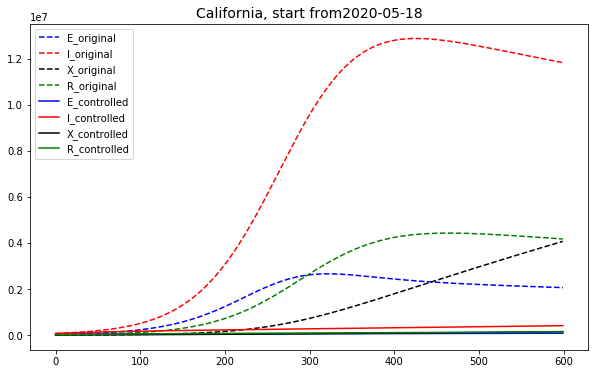

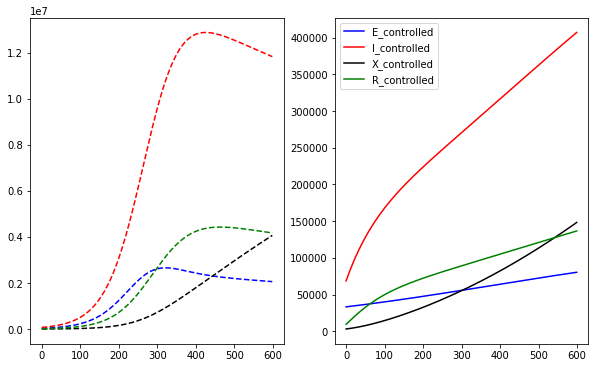

In [14]:
# control the infection rate to 0.1% of the whole population
params = control("California", np.datetime64("2020-05-18"), "case", 5e-3)

#### 2.2. Control for case, 0.5%
The model suggests to have a more relaxed policy for the citizens ($\lambda$ increases) and a stricter quarantine for the positive cases ($c$ decreases). Although it seems that an outbreak is avoided, but the increasing trend of deaths is worrying.

Params:
k: 0.95978763 ; sigma: 0.07142857 ; alpha: 0.03497201 ; omega: 0.00091574 ; miu: 0.01212794
Optimization for lamda, c
params0:  [0.04972483, 0.4054014]
params:  [0.07331898, 0.00140155]


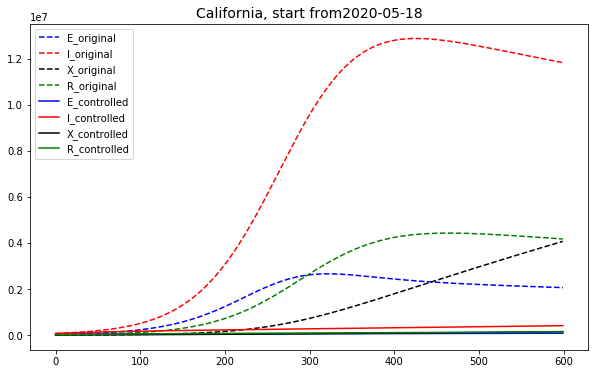

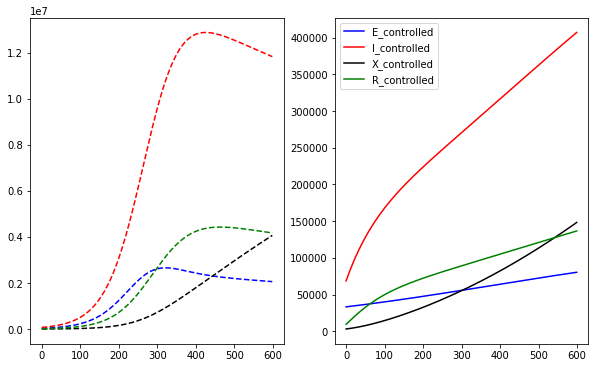

In [6]:
# control the infection rate to 0.5% of the whole population
params = control("California", np.datetime64("2020-05-18"), "case", 5e-3)